In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io.wavfile as wavutils
from sklearn.linear_model import LinearRegression
from typing import Tuple

from scipy.interpolate import interp1d


def freq_calc(sig: np.ndarray, Ss: int) -> float:
    """Calculates the average frequency of the input signal (of a recorded note)"""
    rep = 0
    for i in range(int(len(sig) / 3), int(2 * len(sig) / 3)):
        if sig[i + 1] >= 0 and sig[i] <= 0:
            rep += 1
    return Ss / (len(sig) / (3 * rep))


def make_octaves() -> np.ndarray:
    """Creates Octaves with their corresponding frequency"""
    C4_octave = [261.62556530059874]  # Value of C4
    for _ in range(11):
        C4_octave.append(C4_octave[-1] * 2**(1 / 12))
    C4_octave = np.array(C4_octave)
    return np.array([
        C4_octave / 8, C4_octave / 4, C4_octave / 2, C4_octave, C4_octave * 2,
        C4_octave * 4, C4_octave * 8, C4_octave * 16
    ])


def get_note(freq: float) -> Tuple[float, str]:
    """
    Returns the Note (and its Natural Frequency)
    corresponding to input frequency
    """
    if freq < 30.0:
        raise ValueError(f'{freq} Hz too low')

    f = []
    FREQ = make_octaves()
    for i in FREQ:
        f.extend(i)

    notes = ('C', 'C\u266f-D\u266d', 'D', 'D\u266f-E\u266d', 'E', 'F',
             'F\u266f-G\u266d', 'G', 'G\u266f-A\u266d', 'A', 'A\u266f-B\u266d',
             'B')

    for i in enumerate(f):
        if freq < i[1]:
            note = (f[i[0] - 1], f[i[0]])
            y = divmod(i[0], 12)
            mid = (note[0] + note[1]) / 2
            if freq < mid:
                return note[0], '{} {}'.format(notes[y[1] - 1], y[0] + 1)

            return note[1], '{} {}'.format(notes[y[1]], y[0] + 1)
    else:
        raise ValueError(f'{freq} Hz too high')


def create_partial_envelope(sig: np.ndarray, Fs: int, Ss: int) -> np.ndarray:
    """
    Creates a partial envelope using min and max of in one cycle.
    """

    max_val = []
    # min_val = []
    for i in range(0, len(sig), 1 + (Ss // Fs)):
        max_val.append(max(sig[i:i + Ss // Fs]))
        # min_val.append(min(sig[i:i + Ss//Fs]))
    return np.array(max_val)


def make_natural_env(env: np.ndarray, Ns: int) -> np.ndarray:
    """
    Returns an envelope in natural time for the
    signal by upsampling and uniforming partial envelope
    """
    divs = (Ns // len(env))
    y = np.zeros(Ns)
    for i in range(len(env) - 1):
        y[i * divs:divs * (i + 1)] = np.linspace(env[i], env[i + 1], num=divs)
    return y


def create_env(sig: np.ndarray, Fs: int, Ss: int, Ns: int) -> np.ndarray:
    """return envelope of signal"""
    return make_natural_env(create_partial_envelope(sig, Fs, Ss), Ns)


def find_Ns(Freq: float, Ss: int) -> int:
    """Finds the Ns for Training Phase"""
    return 4 * ((Ss // Freq) + 1)


def find_maxsig(sig: np.ndarray, Ns: int) -> np.ndarray:
    """returns part of signal where its in constant sustain"""
    min1 = 10e9
    sig_ret = np.array(sig[0:Ns])
    for i in range(1, len(sig) // Ns):
        # print(i)
        if (32768 - np.max(sig[i * Ns:(i + 1) * Ns])) < min1:
            min1 = (32768 - np.max(sig[i * Ns:(i + 1) * Ns]))
            sig_ret = sig[i * Ns:(i + 1) * Ns]

    return sig_ret


In [2]:
from typing import Tuple

import scipy.signal as sig
from scipy.signal import butter, freqz, lfilter




def sigin(wavname: str) -> Tuple[int, np.ndarray]:
    """Functions that reads wave file and return sample rate and signal as np.array"""
    return wavutils.read(wavname, mmap=False)


def sawtooth(fs: int, Ns: int, Ss: int) -> np.ndarray:
    """Returns a Sawtooth wave of Sample rate Ss with Ns number of samples and Sample Frequency Fs"""
    Ss = np.linspace(0, 1, Ss)
    return sig.sawtooth(2 * np.pi * fs * Ss)[0:Ns]


def triangle(fs: int, Ns: int, Ss: int) -> np.ndarray:
    """Returns a Triangle wave of Sample rate Ss with Ns number of samples and Sample Frequency Fs"""
    Ss = np.linspace(0, 1, Ss)
    return sig.sawtooth(2 * np.pi * fs * Ss, 0.5)[0:Ns]


def sin(fs: int, Ns: int, Ss: int) -> np.ndarray:
    """Returns a Sine wave of Sample rate Ss with Ns number of samples and Sample Frequency Fs"""
    t = np.arange(Ns)
    omega = 2 * np.pi * fs / Ss
    return np.sin(omega * t)


def cos(fs: int, Ns: int, Ss: int) -> np.ndarray:
    """Returns a Cosine wave of Sample rate Ss with Ns number of samples and Sample Frequency Fs"""
    t = np.arange(Ns)
    omega = 2 * np.pi * fs / Ss
    return np.cos(omega * t)


# Check tests3 in signals-systems to write these functions


def filt_lp(sig: np.ndarray, Ss: int, Cfs: int, Cfs1: None,
            order=5) -> np.ndarray:
    """return a filtered signal; low pass filter"""
    nyq = 0.5 * Ss
    normal_cutoff = Cfs / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, sig)


def filt_hp(sig: np.ndarray, Ss: int, Cfs: int, Cfs1: None,
            order=5) -> np.ndarray:
    """return a filtered signal; high pass filter"""
    nyq = 0.5 * Ss
    normal_cutoff = Cfs / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return lfilter(b, a, sig)


def filt_bp(sig: np.ndarray, Ss: int, Cfs0: int, Cfs1: None,
            order=5) -> np.ndarray:
    """return a filtered signal; band pass filter"""
    nyq = 0.5 * Ss
    normal_cutoff1 = Cfs0 / nyq
    normal_cutoff2 = Cfs1 / nyq
    b, a = butter(order, (normal_cutoff1, normal_cutoff2),
                  btype='band',
                  analog=False)
    return lfilter(b, a, sig)


In [3]:

def create_FunctionFrame(fs: int, Ns: int, Ss: int) -> pd.DataFrame:
    """
    Takes Sampling Frequency and returns a DataFrame
    with function vectors of frequencies
    """

    FuncFrame = pd.DataFrame()
    # Made a dictionary with key as func name and value ad function object
    Functions = {
        "sin": sin,
        "cos": cos,
        "triangle": triangle,
        "sawtooth": sawtooth
    }

    # Iterated on dictionary items
    for i in Functions.items():
        for j in range(1, 11):
            FuncFrame[i[0] + str(j)] = i[1](j * fs, Ns, Ss)

    # Add 1 Column filled with noise to FuncFane without forgetting

    return FuncFrame


def train_S3(FuncFrame: pd.DataFrame, sig: np.ndarray) -> LinearRegression:
    """
    Function That trains FuncFrame on input signal

    Returns:
        LinearRegression
    """

    reg = LinearRegression()
    reg.fit(FuncFrame, sig)
    return reg


def predict_fs(fs: int, Ns: int, Ss: int, reg: LinearRegression) -> np.ndarray:
    """Returns predicted signal of given frequency"""
    FuncFrame = create_FunctionFrame(fs, Ns, Ss)
    pred_sig = reg.predict(FuncFrame)
    return pred_sig


In [4]:
# from pyo import *

# s = Server().boot()

# # A four-streams oscillator to produce a chord.
# osc = SineLoop(freq=[0, 0, 0, 0], feedback=0.05, mul=.2)
# rev = WGVerb(osc.mix(2), feedback=0.8, cutoff=4000, bal=0.2).out()

# def set_osc_freqs(notes):
#     # PyoObject.set() method allow to change the value of an attribute
#     # with an audio ramp to smooth out the change.
#     osc.set(attr="freq", value=midiToHz(notes), port=0.005)

# # The sequence of functions (some call set_osc_freqs to change the notes).
# def event_0():
#     set_osc_freqs([60, 64, 67, 72])

# def event_1():
#     pass

# def event_2():
#     set_osc_freqs([60, 64, 67, 69])

# def event_3():
#     pass

# def event_4():
#     set_osc_freqs([60, 65, 69, 76])

# def event_5():
#     pass

# def event_6():
#     set_osc_freqs([62, 65, 69, 74])

# def event_7():
#     set_osc_freqs([59, 65, 67, 74])

# # Integer generator (more about triggers in section 12-triggers)
# metro = Metro(time=0.5).play()
# count = Counter(metro, min=0, max=8)

# # Score calls the function named "event_" + count. (if count is 3,
# # function named "event_3" is called without argument.
# score = Score(count, fname="event_")

# s.gui(locals())

In [5]:
# from pyo import *
# from random import random

# class Synth:
#     def __init__(self, transpo=1, mul=1):
#         # Transposition factor.
#         self.transpo = Sig(transpo)
#         # Receive midi notes, convert pitch to Hz and manage 10 voices of polyphony.
#         self.note = Notein(poly=10, scale=1, first=0, last=127)

#         # Handle pitch and velocity (Notein outputs normalized amplitude (0 -> 1)).
#         self.pit = self.note['pitch'] * self.transpo
#         self.amp = MidiAdsr(self.note['velocity'], attack=0.001,
#                             decay=.1, sustain=.7, release=1, mul=.1)

#         # Anti-aliased stereo square waves, mixed from 10 streams to 1 stream
#         # to avoid channel alternation on new notes.
#         self.osc1 = LFO(self.pit, sharp=0.5, type=2, mul=self.amp).mix(1)
#         self.osc2 = LFO(self.pit*0.997, sharp=0.5, type=2, mul=self.amp).mix(1)

#         # Stereo mix.
#         self.mix = Mix([self.osc1, self.osc2], voices=2)

#         # High frequencies damping.
#         self.damp = ButLP(self.mix, freq=5000)

#         # Moving notches, using two out-of-phase sine wave oscillators.
#         self.lfo = Sine(.2, phase=[random(), random()]).range(250, 4000)
#         self.notch = ButBR(self.damp, self.lfo, mul=mul)

#     def out(self):
#         "Sends the synth's signal to the audio output and return the object itself."
#         self.notch.out()
#         return self

#     def sig(self):
#         "Returns the synth's signal for future processing."
#         return self.notch

# s = Server()
# s.setMidiInputDevice(99) # Open all input devices.
# s.boot()

# # Create the midi synth.
# a1 = Synth()

# # Send the synth's signal into a reverb processor.
# rev = STRev(a1.sig(), inpos=[0.1, 0.9], revtime=2, cutoff=4000, bal=.15).out()

# # It's very easy to double the synth sound!
# # One octave lower and directly sent to the audio output.
# a2 = Synth(transpo=0.5, mul=0.7).out()

# s.gui(locals())

In [6]:
class Envelope:
    def __init__(self, sig: np.ndarray, Fs: int, Ns: int, Ss: int):
        self.init_env = create_env(sig, Fs, Ss, Ns)
        self.env = self.init_env
        self.Ns = Ns

    def create_env_s3(self, initalenv: np.ndarray, Ns: int):
        self.env = initalenv


class S3App:
    """Class to manage  interface of S3 Synthesiser """
    def __init__(self):
        pass

    def load_file(self, file_path: str):
        """Loads a Sample into the synthesiser"""
        self.Ss, self.wave = sp.io.wavfile.read(file_path, mmap=False)
        self.wave=np.array(self.wave[:, 0])
        self.wave=self.wave/max(self.wave)

    def load_trainedsynth(self):
        """Loads all properties of S3 trains S3 and initialises S3Synth"""
        # plt.plot(self.wave)
        freq = freq_calc(self.wave, self.Ss)
        self.Ss = int(self.Ss)
        self.freq, self.note = get_note(freq)
        self.Ns = int(find_Ns(self.freq, self.Ss))
        self.Fs = int(freq)
        print(freq, self.Ns, self.Ss, self.note)
        self.wave_sampled = find_maxsig(self.wave, self.Ns)
        self.env = Envelope(self.wave, self.Fs, len(self.wave), self.Ss)
        # plt.plot(self.env.env)
        print(self.env.Ns)
        func_frame = create_FunctionFrame(self.Fs, self.Ns, self.Ss)
        self.reg = train_S3(func_frame, self.wave_sampled)
        print(self.reg.score(func_frame, self.wave_sampled))
#         self.s3 = S3Synth(make_octaves(), self.reg, self.Ns, self.Ss)
#         self.s3.enveloped_keyframe(self.env)

    def filter_synth(self, filter_type: str, Cfs: int, Cfs1=None):
        self.s3.changed_filter(filter_type, self.env, Cfs, Cfs1)


In [7]:
kaypee = S3App()
kaypee.load_file('flute1.wav')
print(max(kaypee.wave))
# plt.plot(kaypee.wave[60000:60400])
# plt.show()
kaypee.load_trainedsynth()

1.0
1007.789824854045 180 44100 B 6
89925
0.992113905744692


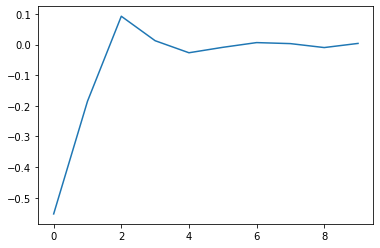

In [8]:
plt.plot(kaypee.reg.coef_[0:10])

In [9]:
from pyo import *

s = Server().boot()
s.start()

sf = SfPlayer("flute1.wav", loop=True, mul=.4)
fol = Follower(sf)
# n = Noise(mul=fol).out(1)



# Sets fundamental frequency and highest harmonic.
freq = 523
high = 20

globalamp = Fader(fadein=2, fadeout=2, dur=0).play()

# Envelope for discrete events, sharp attack, long release.
env = Adsr(attack=0.1, decay=0.1, sustain=0.4, release=1.5, dur=2, mul=0.5)
# setExp method can be used to create exponential or logarithmic envelope.
env.setExp(0.75)



# Generates lists for frequencies and amplitudes
harms = [freq * i for i in range(1, high) ]
amps = list(kaypee.reg.coef_)

# Creates a square wave by additive synthesis.
a = Sine(freq=harms, mul=amps,phase=[0,0,0,0,0,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
print("Number of Sine streams: %d" % len(a))

# Mix down the number of streams of "a" before computing the Chorus.
b = Chorus(a.mix(8), feedback=0.5,mul=fol,bal=0.75)
print("Number of Chorus streams: %d" % len(b))
harms1 = [587 * i for i in range(1, high) ]
aa = Sine(freq=harms1, mul=amps,phase=[0,0,0,0,0,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
print("Number of Sine streams: %d" % len(a))

# Mix down the number of streams of "a" before computing the Chorus.
bb = Chorus(aa.mix(8), feedback=0.5,mul=fol,bal=0.75)
print("Number of Chorus streams: %d" % len(b))
harms2 = [659 * i for i in range(1, high) ]
aaa = Sine(freq=harms2, mul=amps,phase=[0,0,0,0,0,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
print("Number of Sine streams: %d" % len(a))

# Mix down the number of streams of "a" before computing the Chorus.
bbb = Chorus(aaa.mix(8), feedback=0.5,mul=fol,bal=0.75)
print("Number of Chorus streams: %d" % len(b))



harms3 = [1008 * i for i in range(1, high) ]
aa2 = Sine(freq=harms3, mul=amps,phase=[0,0,0,0,0,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
print("Number of Sine streams: %d" % len(a))
Orig=Mix(aa2,mul=fol,voices=8)

# Mix down the number of streams of "a" before computing the Chorus.
bb2 = Chorus(aa2.mix(), feedback=0.5,mul=fol,bal=0.75)
print("Number of Chorus streams: %d" % len(b))
# d=Mix(aa2,mul=fol)
c=STRev(Orig, inpos=0.25,mul=4, revtime=2, cutoff=5000, bal=0.75, roomSize=0.4)
# d=STRev(sf, inpos=0.25,mul=4, revtime=2, cutoff=5000, bal=0.75, roomSize=0.4)

env.play()
b.out()
import time; time.sleep(2)
b.stop()
env.play()
bb.out()
time.sleep(2)
bb.stop()
env.play()
bbb.out()
time.sleep(2)
bbb.stop()
bb2.out()
time.sleep(2)
bb2.stop()
Orig.out()
time.sleep(2)
Orig.stop()
c.out()
time.sleep(2)
c.stop()
# b.stop()
sf.out()
time.sleep(2)
sf.stop()


# s.gui(locals())


Number of Sine streams: 40
Number of Chorus streams: 8
Number of Sine streams: 40
Number of Chorus streams: 8
Number of Sine streams: 40
Number of Chorus streams: 8
Number of Sine streams: 40
Number of Chorus streams: 8


< Instance of SfPlayer class >

In [10]:
s.stop()

In [11]:
# from pyo import *

# s = Server().boot()
# s.amp = 0.1

# # Creates a sine wave as the source to process.
# a = Sine().out()

# # Passes the sine wave through an harmonizer.
# h1 = Harmonizer(a).out()

# # Then the harmonized sound through another harmonizer.
# h2 = Harmonizer(h1).out()

# # And again...
# h3 = Harmonizer(h2).out()

# # And again...
# h4 = Harmonizer(h3).out()

# s.gui(locals())

In [12]:
dir(bb2)

['add', 'bal', 'depth', 'feedback', 'input', 'mul']

In [15]:
dir(bb2.input)

['add', 'mul']

In [17]:
bb2.input.mul

1